In [1]:
import pickle
import numpy as np
import pandas as pd
import math
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from bisect import bisect_left
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from quadtreev2 import Point, Node, QTree
from matplotlib import gridspec
from quadtreev2 import find_children

/blue/zhe.jiang/whe2/conda/envs/redtide/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIME_WINDOW = 700
longest_window = 1000
regression  = True
homepath = '/blue/zhe.jiang/whe2/band2/1000_50/'
if not os.path.exists(homepath):
    os.mkdir(homepath)
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList) - 1
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos
    else:
        return pos - 1
def calCord(latarray, longarray):
    xaxis = []
    yaxis = []
    for i in range(latarray.shape[0]): 
        lat = latarray[i]
        long = longarray[i]
        
        latMid = (lat+minlat )/2.0


        m_per_deg_lat = (111132.954 - 559.822 * math.cos( 2.0 * latMid ) + 1.175 * math.cos( 4.0 * latMid)) / 1e5
        m_per_deg_lon = ((3.14159265359/180 ) * 6367449 * math.cos ( latMid ))/1e5

        deltaLat = math.fabs(lat - minlat)
        deltaLon = math.fabs(long - minlong)
        
        xaxis.append(deltaLat * m_per_deg_lat)
        yaxis.append(deltaLon * m_per_deg_lon )
    
    return np.array(xaxis), np.array(yaxis) 

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def DepthNorm(name, par, depth):
    keys = np.load(data_path + name + '_keys.npy')
    means = np.load(data_path + name+ '_means.npy')
    stds = np.load(data_path + name + '_stds.npy')
    
    feature_norm = []
    for i in range(len(par)):
        depth_val = -depth[i]
        if not np.isnan(depth_val):
            indices = take_closest(keys, depth_val)
            #print(indices)
        else:
            indices = take_closest(keys, -1)
        #print(len(indices))
        #print(indices)
        #assert len(indices) >= 1
                                                    
        mean_val = means[indices]
        std_val = stds[indices]
        new_val = (par[i] - mean_val) / (std_val + 1e-3)
        feature_norm.append(new_val)
        
    
    return feature_norm

def findLargestIndex(time, specific_index):
    index = specific_index - 1
    while True:
        if index < 0 or time[index] < time[specific_index]:
            break
        else:
            index = index - 1
    return index

def NormalizeDataMultiDim(data):
    for i in range(data.shape[1]):
        if not np.isnan ((np.max(data[:, i]) - np.min(data[:,i]))):
            data[:,i] = (data[:,i] - np.min(data[:,i])) / (np.max(data[:, i]) - np.min(data[:,i]))
    return data

def shuffle_data_label(data, label):
    shuffler = np.random.permutation(len(label))
    data_shuffled = data[shuffler]
    label_shuffled = label[shuffler]
    return data_shuffled, label_shuffled

def prepareDataset(features_st,label, TIME_WINDOW): 
    time = features_st[:, -1]
    features_concat = []
    label_concat = []
    for i in range(features_st.shape[0]):
        idx_end = findLargestIndex(time, i)
        idx_start = idx_end + 1  - TIME_WINDOW
        if idx_start > 0:
            features_neigh = features_st[idx_start:idx_end + 1, :]
            features_i = features_st[i,:]
            features_i = np.expand_dims(features_i, axis = 0)
            #features_i = np.expand_dims(features_i, axis = 0)
            #features_neigh = np.expand_dims(features_neigh, axis = 0)
            features_concat_i = np.concatenate((features_i, features_neigh), axis = 0)
            features_concat.append(features_concat_i)
            label_concat.append(label[i])
    return np.array(features_concat),np.array(label_concat)

with open('data/paired_dataset.pkl', 'rb') as f:
    paired_data = pickle.load(f)
file_errors_location = 'data/PinellasMonroeCoKareniabrevis 2010-2020.06.12.xlsx'
df = pd.read_excel(file_errors_location)
for name in ['par', 'chlor_a', 'Rrs_443','Rrs_469','Rrs_488', 'Kd_490', 'nflh']:
    df[name] = 0
df = df.sort_values('Sample Date')
df_unix_sec = (pd.to_datetime(df['Sample Date'])).astype(int)/10**9
df_unix_sec = df_unix_sec.to_numpy()
#df_unix = (df_unix_sec - df_unix_sec[0])/(df_unix_sec[3] - df_unix_sec[0])
#df['Sample Date'] = df_unix
#da_new = df[['Sample Date', 'Sample Depth (m)', 'Latitude','Longitude','Karenia brevis abundance (cells/L)' ]]
#da_new = da_new.to_numpy()

time_df = df_unix_sec
lat_df = df['Latitude']
long_df = df['Longitude']
concen_df = df['Karenia brevis abundance (cells/L)']

length = len(time_df)
features_df = df['par'].to_numpy().reshape(length,1)
for name in [ 'chlor_a', 'Rrs_443','Rrs_469','Rrs_488', 'Kd_490', 'nflh','Karenia brevis abundance (cells/L)']:
    features_df = np.concatenate((features_df, df[name].to_numpy().reshape(length,1)),axis = 1)



paired_data = paired_data.sort_values('Sample Date')
depth = paired_data['Sample Depth']
time_paired = paired_data['Sample Date']
time_paired = (pd.to_datetime(time_paired)).astype(int)/10**9
time_paired = time_paired.to_numpy() 



lat_paired = paired_data['Latitude']
long_paired = paired_data['Longitude']
lat_paired = lat_paired.to_numpy()
long_paired = long_paired.to_numpy()
maxlat_paired = np.max(lat_paired)
minlat_paired = np.min(lat_paired)
maxlong_paired = np.max(long_paired)
minlong_paired = np.min(long_paired)


par = paired_data['par']
par = par.to_numpy()
chlor_a = paired_data['chlor_a']
chlor_a = chlor_a.to_numpy()
Rrs_443 = paired_data['Rrs_443']
Rrs_443 = Rrs_443.to_numpy()
Rrs_469 = paired_data['Rrs_469']
Rrs_469 = Rrs_469.to_numpy()
Rrs_488 = paired_data['Rrs_488']
Rrs_488 = Rrs_488.to_numpy()
Kd_490 = paired_data['Kd_490']
Kd_490 = Kd_490.to_numpy()
nflh = paired_data['nflh']
nflh = nflh.to_numpy()

data_path = 'data/depth_stats/'
par_norm = DepthNorm('par',par,depth)
chlor_a_norm = DepthNorm('chlor_a', chlor_a, depth)
Rrs_443_norm = DepthNorm('Rrs_443', Rrs_443, depth)
Rrs_469_norm = DepthNorm('Rrs_469', Rrs_469, depth)
Rrs_488_norm = DepthNorm('Rrs_488', Rrs_488, depth)
Kd_490_norm = DepthNorm('Kd_490', Kd_490, depth)
nflh_norm = DepthNorm('nflh', nflh, depth)

concen_paired = paired_data['Red Tide Concentration']

features_paired = np.stack((par_norm, chlor_a_norm, Rrs_443_norm,Rrs_469_norm,Rrs_488_norm, Kd_490_norm, nflh_norm,concen_paired), axis = 1) 
#features = NormalizeDataMultiDim(features)
#features = np.stack((par, chlor_a, Rrs_443,Rrs_469,Rrs_488, Kd_490, nflh), axis = 1) 

time = np.concatenate((time_df, time_paired), axis = 0)
lat = np.concatenate((lat_df, lat_paired), axis = 0)
long = np.concatenate((long_df, long_paired), axis = 0)
features = np.concatenate((features_df, features_paired), axis = 0)
data_array = np.stack((time, lat, long),axis = 1) 
data_array = np.concatenate((data_array,features), axis = 1)
ind = np.argsort( data_array[:,0] )
data_array = data_array[ind]

time = data_array[:, 0]
time = (time  -  time[0]) / (time[3] - time[0])

lat = data_array[:,1]
long = data_array[:, 2]
features = data_array[:,3:]

concen = np.copy(features[:, -1])
features[:, -1] = np.log(concen + 1)
#concen_mean= np.mean(concen)
#concen_std = np.std(concen)
#concen = (concen - concen_mean) / concen_std

label = np.copy(concen)


if regression:
    label = np.log10(label+1)
    #label = label/np.max(label)
else:
    label = (label > 1e5)
    label = label.astype('uint8')



minlat = np.min(lat)
minlong = np.min(long)
xaxis, yaxis = calCord(np.copy(lat), np.copy(long))
locations = np.stack((xaxis, yaxis), axis = 1)
locations_latlong =  np.stack((lat, long), axis = 1)


def RemoveNan(features, time, locations, locations_latlong, label,concen):
    features_new = []
    time_new = []
    locations_new = []
    locations_latlong_new = []
    label_new = []
    concen_new = []
    
    for i in range(features.shape[0]):
        #flag = 1
        for j in range(features.shape[1]):
            if np.isnan(features[i,j]):
                break;
            if (j == features.shape[1] - 1):
                features_new.append(features[i,:])
                time_new.append(time[i])
                locations_new.append(locations[i,:])
                locations_latlong_new.append(locations_latlong[i,:])
                label_new.append(label[i])
                concen_new.append(concen[i])
    return np.array(features_new), np.array(time_new), np.array(locations_new),np.array(locations_latlong_new), np.array(label_new), np.array(concen)

features, time, locations, locations_latlong, label,concen = RemoveNan(features, time, locations,locations_latlong, label,concen)  

time = time.reshape(len(time), 1)
features_st = np.concatenate((features, locations_latlong, time), axis = 1) # -1 time, -2 and -3 locations, -4 concen

features_data, label_data = prepareDataset(features_st, label, TIME_WINDOW)

# train_instance = int(np.shape(features_data)[0]*0.7)
# val_instance = int(np.shape(features_data)[0]*0.8)

# train_data = features_data[:train_instance]
# train_label = label_data[:train_instance]

# val_data = features_data[train_instance:val_instance]
# val_label = label_data[train_instance:val_instance]

# test_data = features_data[val_instance:]
# test_label = label_data[val_instance:]

# def data_augumentation(train_data, train_label,aug_times = 10):
#     new_train_data = []
#     new_train_label = []
#     for i in range(len(train_label)):
#         if(train_label[i]>=5):
#             new_train_data.extend([train_data[i] for j in range(aug_times)])
#             new_train_label.extend([train_label[i] for j in range(aug_times)])
    
#     new_train_data = np.array(new_train_data)
#     new_train_label = np.array(new_train_label)
#     train_data = np.concatenate((train_data,new_train_data), axis = 0)
#     train_label = np.concatenate((train_label, new_train_label), axis = 0)
    
#     return train_data, train_label

# train_data, train_label = data_augumentation(train_data, train_label,aug_times = 10)
    
#time = NormalizeData(time)
#locations = NormalizeDataMultiDim(locations)

In [ ]:
long = features_st[:,-2]
lat = features_st[:,-3]
lat_min,lat_max = np.min(lat)-0.5, np.max(lat) + 0.5
long_min, long_max = np.min(long) - 0.5, np.max(long)+ 0.5

features_data, label_data = prepareDataset(features_st, label, TIME_WINDOW)

In [4]:
def recursive_node(node, virtual_node_index):
    virtual_node_index[node.virtual_index]= [int(point.index) for point in node.points] 
    for child in node.children:
        recursive_node(child, virtual_node_index)
    return 


def leaf_to_real_mask(leaf_mask):
    #new_mask = []
    order = 0
    path = homepath +  'sparse_mask/'
    if not os.path.exists(path):
        os.mkdir(path)
    
    for mask in leaf_mask:
        i_mask = np.ones((TIME_WINDOW+1,longest_window), dtype=bool)
        for row in range(len(mask)):
            i_mask[row][mask[row]] = False
        sparse_i_mask = sparse.csr_matrix(i_mask)
        
        loc = homepath +  'sparse_mask/' + str(order) + 'mask_mat.npz'
        sparse.save_npz(loc, sparse_i_mask)
        order = order + 1
    return 

def virtual_to_downsample_feature(virtual_mask):
    #downsample_mat = []
    order = 0
    path = homepath +  'sparse_downsample/'
    if not os.path.exists(path):
        os.mkdir(path)
    for vir_mask in virtual_mask:
        down_mat = np.zeros((longest_window,TIME_WINDOW+1), int)
        np.fill_diagonal(down_mat, 1)
        for key in vir_mask.keys():
            down_mat[key] = 0
            down_mat[key][vir_mask[key]] = 1
            # if len(vir_mask[key]==0):
            #     down_mat[key] = 1
        row_sums = down_mat.sum(axis=1)
        down_mat = down_mat / (row_sums[:, np.newaxis]+1e-5)
        sparse_down_mat = sparse.csr_matrix(down_mat)
        loc = homepath +  'sparse_downsample/' + str(order) + 'downsample_mat.npz'
        sparse.save_npz(loc, sparse_down_mat)
        order = order + 1
        #downsample_mat.append(down_mat)
    return 

In [6]:
DPI = 72
np.random.seed(790)
width, height = lat_max - lat_min,  long_max- long_min



leaf_mask = []
virtual_mask = []
for i in range(len(features_data)):

    coord = features_data[i][:,-3:-1]
    coord_nozero = coord[np.where(coord[:,0]!=0)[0],:]#coord[np.where(coord!=0)[0],:]
    
    index = np.arange(0, len(coord_nozero), 1, dtype=int)
    index = index.reshape(len(index), 1)
    coords = np.concatenate((coord_nozero, index), axis = -1)
    points_set = [Point(*coord) for coord in coords]
    domain =[lat_min,long_min,width, height] #Rect((lat_max + lat_min)/2, (long_max + long_min)/2, width, height)
    qtree = QTree(20, points_set, domain)

    qtree.subdivide()

    allchildren_set = find_children(qtree.root)

    all_mask = []
    for _ in range(len(coord_nozero)):
        all_mask.append([])

    ### get leaf node mask
    mask_num = 0
    for node in allchildren_set:
        ori_node = node
        non_mask = [point.index for point in node.points]
        cur_node = node
        node = node.parent
        while node!=None:
            children_virtual_index_set = [virtual_node.virtual_index for virtual_node in node.children]
            children_virtual_index_set.remove(cur_node.virtual_index)
            for virtual_index in children_virtual_index_set:
                non_mask.append(virtual_index)
            cur_node = node
            node = node.parent
        for inv_point in ori_node.points:
            mask_num = mask_num + 1
            all_mask[int(inv_point.index)] = list(map(round, non_mask)) 
    assert mask_num==len(coord_nozero), i
    
    # for j in range(len(coord_nozero), longest_window):
    #     all_mask.append([j])
    leaf_mask.append(all_mask)

    ### get virtual node mask

    virtual_node_mask = {}
    node = qtree.root
    node_index = node.virtual_index
    recursive_node(node, virtual_node_mask)
    
    virtual_mask.append(virtual_node_mask)
    

Calculate the maximum mask list length

In [7]:
max_length = 0
for mask in leaf_mask:
    length = [len(mask[i]) for i in range(len(mask))]
    max_length = max(length + [max_length])
#max_length = min(30, max_length)
max_length = min(30, max_length)

Save leaf mask. 

In [10]:
new_leaf_mask = []
for mask in leaf_mask:
    for i in range(len(mask)):
        cur_list_len = len(mask[i])
        if cur_list_len < max_length:
            mask[i] = mask[i] + [longest_window for _ in range(max_length - cur_list_len)]
        if cur_list_len > max_length:
            mask[i] = mask[i][:max_length]
    new_leaf_mask.append(mask)
    

In [13]:
a=1

In [11]:
import pickle
path = homepath +  'list_mask/'
if not os.path.exists(path):
    os.mkdir(path)
loc = homepath +  'list_mask/'  + 'mask_mat.pickle'
with open(loc, 'wb') as handle:
    pickle.dump(new_leaf_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)


Save Mask

Save downsample

In [14]:
virtual_to_downsample_feature(virtual_mask)

Illustruction on the quadtree code and visualization

In [5]:
leaf_mask = []
virtual_mask = []
DPI = 72
np.random.seed(790)
width, height = lat_max - lat_min,  long_max- long_min


i =30000

###Construct quadtree for i th sample sequence

coord = features_data[i][:,-3:-1] ## extract the point sequence coordinates (n, x,y)
coord_nozero = coord[np.where(coord[:,0]!=0)[0],:]   ##exclude those points with null location information

index = np.arange(0, len(coord_nozero), 1, dtype=int)
index = index.reshape(len(index), 1)
coords = np.concatenate((coord_nozero, index), axis = -1) ## point location and index 
points_set = [Point(*coord) for coord in coords]    ## construct point set with point cloass
domain =[lat_min,long_min,width, height] #Rect((lat_max + lat_min)/2, (long_max + long_min)/2, width, height)
qtree = QTree(20, points_set, domain)  ## initialize qtree class with point set input / no graph structure 

qtree.subdivide() ## construct the graph structure 

allchildren_set = find_children(qtree.root)  

all_mask = []
for _ in range(len(coord_nozero)):
    all_mask.append([])

### get leaf node mask
mask_num = 0
for node in allchildren_set:
    ori_node = node
    non_mask = [point.index for point in node.points]
    cur_node = node
    node = node.parent
    while node!=None:
        children_virtual_index_set = [virtual_node.virtual_index for virtual_node in node.children]
        children_virtual_index_set.remove(cur_node.virtual_index)
        for virtual_index in children_virtual_index_set:
            non_mask.append(virtual_index)
        cur_node = node
        node = node.parent
    for inv_point in ori_node.points:
        mask_num = mask_num + 1
        all_mask[int(inv_point.index)] = list(map(round, non_mask)) 

assert mask_num==len(coord_nozero), i
#leaf_mask.append(all_mask)

### get virtual node mask

virtual_node_mask = {}
node = qtree.root
node_index = node.virtual_index
recursive_node(node, virtual_node_mask)

#virtual_mask.append(virtual_node_mask)

In [6]:
maxnode = 0
for mask_i in [all_mask]:
    for ele in mask_i:
        maxnode = max([maxnode, max(ele)])

In [7]:
maxnode

817

Number of segments: 75
Minimum segment area: 0.000 units


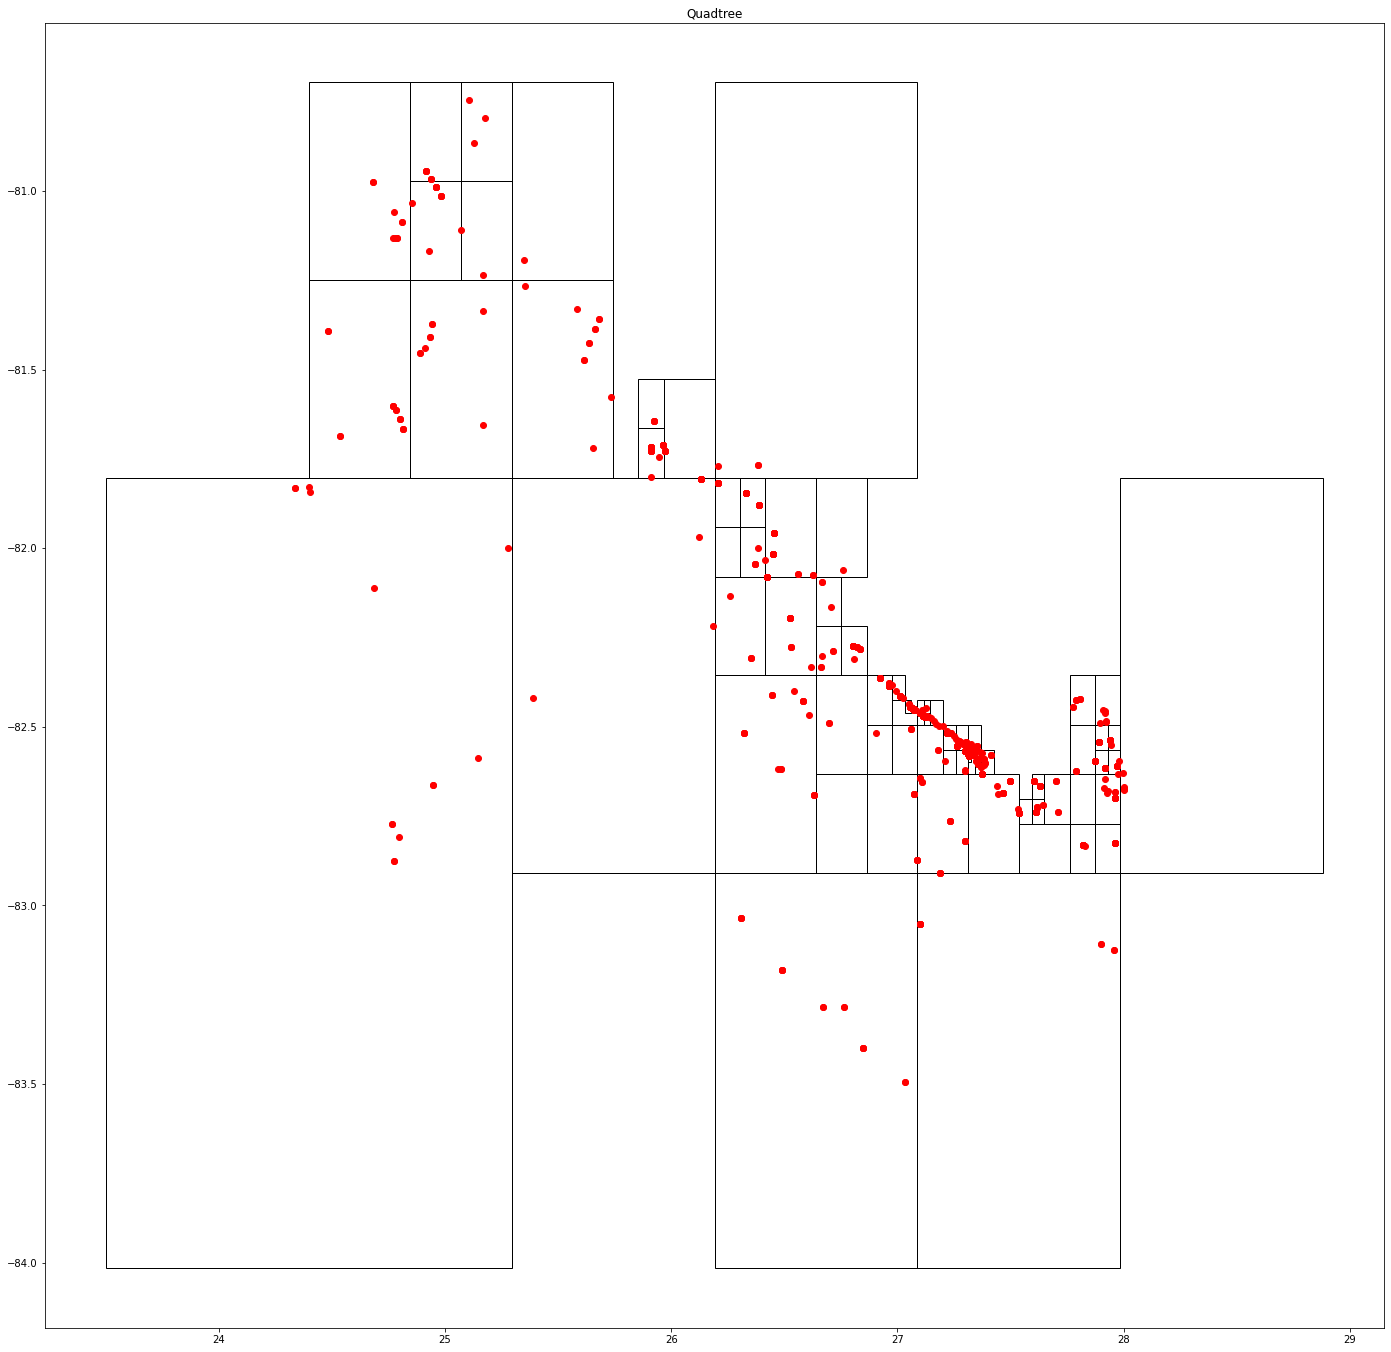

In [8]:
qtree.graph()  ##plot the quadtree structure